Authors: Adema Bauyrzhankyzy , Arlan Manap , Dilnaz Sadyrbayeva, Laura Sepbossynova
Group: CS-2120

In [ ]:
# Installing pyspark library
!pip install pyspark

In [ ]:
# Importing libraries
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import year, month, hour
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
header = ['Unnamed: 0', 'ID', 'Case Number', 'Date', 'Block', 'IUCR',
       'Primary Type', 'Description', 'Location Description', 'Arrest',
       'Domestic', 'Beat', 'District', 'Ward', 'Community Area', 'FBI Code',
       'X Coordinate', 'Y Coordinate', 'Year', 'Updated On', 'Latitude',
       'Longitude', 'Location']

# Reading crime data CSV files
crimes_2001_2004 = pd.read_csv("/content/Chicago_Crimes_2001_to_2004.csv", on_bad_lines='skip')
crimes_2005_2007 = pd.read_csv("/content/Chicago_Crimes_2005_to_2007.csv", on_bad_lines='skip', names=header)
crimes_2008_2011 = pd.read_csv("/content/Chicago_Crimes_2008_to_2011.csv", on_bad_lines='skip')
crimes_2012_2017 = pd.read_csv("/content/Chicago_Crimes_2012_to_2017.csv", on_bad_lines='skip')

# Concatenating into a single DataFrame
crimes_2001_2017 = pd.concat([crimes_2001_2004, crimes_2005_2007, crimes_2008_2011, crimes_2012_2017], ignore_index=True)

<ipython-input-3-f912a2f51599>:8: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  crimes_2001_2004 = pd.read_csv("/content/Chicago_Crimes_2001_to_2004.csv", on_bad_lines='skip')
<ipython-input-3-f912a2f51599>:9: DtypeWarning: Columns (0,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  crimes_2005_2007 = pd.read_csv("/content/Chicago_Crimes_2005_to_2007.csv", on_bad_lines='skip', names=header)
<ipython-input-3-f912a2f51599>:11: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  crimes_2012_2017 = pd.read_csv("/content/Chicago_Crimes_2012_to_2017.csv", on_bad_lines='skip')


In [ ]:
# Drop unnecessary columns
crimes_2001_2017.drop(columns=['Unnamed: 0', 'IUCR','Ward',	'Community Area', 'X Coordinate', 'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude', 'Location'], inplace=True)

# Fill NaN values
crimes_2001_2017["Location Description"].fillna("OTHER", inplace=True)
crimes_2001_2017["District"].fillna(0, inplace=True)

# Drop misfiled cases
crimes_2001_2017.drop_duplicates(inplace=True)
crimes_2001_2017.dropna(subset=["Case Number"], inplace=True)
crimes_2001_2017.dropna(inplace=True)

In [ ]:
crimes_2001_2017.head()

,ID,Case Number,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,FBI Code
0,4786321.0,HM399414,01/01/2004 12:01:00 AM,082XX S COLES AVE,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,False,False,424.0,4.0,06
1,4676906.0,HM278933,03/01/2003 12:00:00 AM,004XX W 42ND PL,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,True,935.0,9.0,26
2,4789749.0,HM402220,06/20/2004 11:00:00 AM,025XX N KIMBALL AVE,OFFENSE INVOLVING CHILDREN,AGG CRIM SEX ABUSE FAM MEMBER,RESIDENCE,False,False,1413.0,14.0,20
3,4789765.0,HM402058,12/30/2004 08:00:00 PM,045XX W MONTANA ST,THEFT,FINANCIAL ID THEFT: OVER $300,OTHER,False,False,2521.0,25.0,06
4,4677901.0,HM275615,05/01/2003 01:00:00 AM,111XX S NORMAL AVE,THEFT,FINANCIAL ID THEFT:$300 &UNDER,RESIDENCE,False,False,2233.0,22.0,06


In [ ]:
print("Descriptive statistics for numerical columns:")
print(crimes_2001_2017.describe())

Descriptive statistics for numerical columns:
                 ID          Beat      District
count  4.564102e+06  4.564102e+06  4.564102e+06
mean   5.683955e+06  1.196622e+03  1.131137e+01
std    2.665162e+06  7.040449e+02  6.947782e+00
min    6.340000e+02  1.110000e+02  0.000000e+00
25%    3.820993e+06  6.230000e+02  6.000000e+00
50%    5.762267e+06  1.111000e+03  1.000000e+01
75%    7.579306e+06  1.732000e+03  1.700000e+01
max    1.082208e+07  2.535000e+03  3.100000e+01


In [ ]:
# Saving DataFrame to a CSV file
crimes_2001_2017.to_csv("Chicago_Crimes_2001_to_2017.csv", index=False)

In [ ]:
sc = SparkSession.builder \
    .appName("CrimeAnalysis") \
    .getOrCreate()

rdd = sc.sparkContext.textFile('/content/Chicago_Crimes_2001_to_2017.csv')

header = rdd.first()
rdd = rdd.filter(lambda row: row != header)

In [ ]:
# Split row by comma
rdd = rdd.map(lambda row: row.split(','))

# Rearrange elements in row
rdd = rdd.map(lambda row: (row[2],) + tuple(row[0:2]) + (row[4], row[5], row[6]) + tuple(row[7:14]))

# Convert timestamp to datetime format
def parse_date(date_str):
    import datetime
    return datetime.datetime.strptime(date_str, '%m/%d/%Y %I:%M:%S %p')

# Apply parse_date to timestamp
rdd = rdd.map(lambda row: (parse_date(row[0]),) + row[1:])

# Extract year, month, day, hour
rdd = rdd.map(lambda row: (row[0], row[0].year, row[0].month, row[0].hour) + row[1:])

In [ ]:
# Counting the number of crimes by year
crime_count_by_year = rdd.map(lambda row: (row[1], 1)).reduceByKey(lambda x, y: x + y).sortByKey()

crime_count_by_year.collect()

[(2001, 484982),
 (2002, 484976),
 (2003, 126048),
 (2004, 1433),
 (2005, 453666),
 (2006, 448036),
 (2007, 436924),
 (2008, 426389),
 (2009, 391595),
 (2010, 247589),
 (2011, 535),
 (2012, 334725),
 (2013, 305760),
 (2014, 273230),
 (2015, 122723),
 (2016, 25491)]

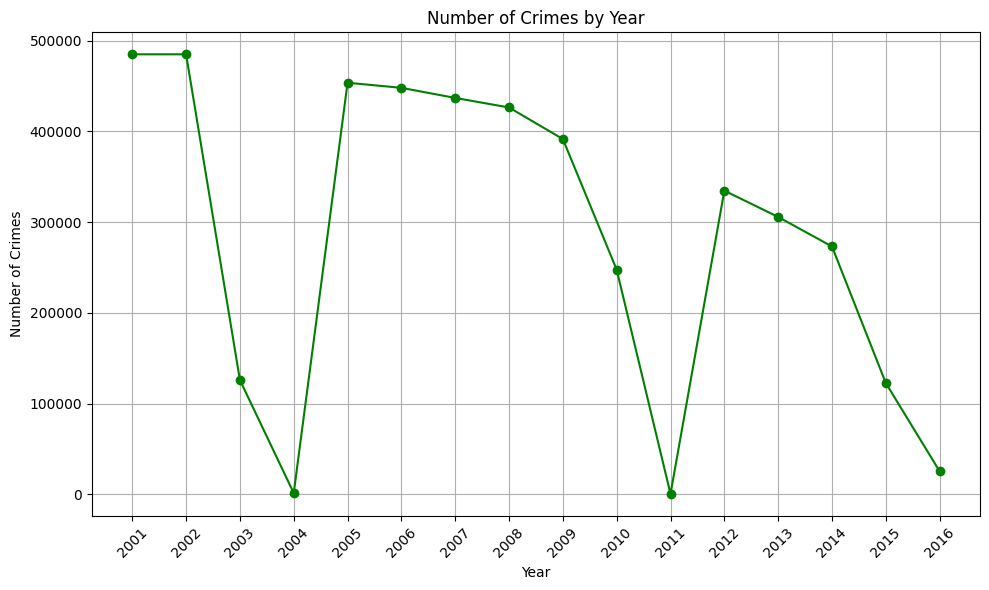

In [ ]:
# Retrieve data
crime_count_by_year_data = crime_count_by_year.collect()

# Split into lists
years = [item[0] for item in crime_count_by_year_data]
crime_counts_year = [item[1] for item in crime_count_by_year_data]

# Plot graph
plt.figure(figsize=(10, 6))
plt.plot(years, crime_counts_year, marker='o', color='green')
plt.title('Number of Crimes by Year')
plt.xlabel('Year')
plt.ylabel('Number of Crimes')
plt.grid(True)
plt.xticks(years, rotation=45)
plt.tight_layout()

# Show graph
plt.show()

In [ ]:
# Counting the number of crimes by months
crime_by_month = rdd.map(lambda row: (row[2], 1)).reduceByKey(lambda x, y: x + y).sortByKey()

crime_by_month.collect()

[(1, 402789),
 (2, 351027),
 (3, 422681),
 (4, 408923),
 (5, 436691),
 (6, 411120),
 (7, 410738),
 (8, 402410),
 (9, 349638),
 (10, 352238),
 (11, 318186),
 (12, 297661)]

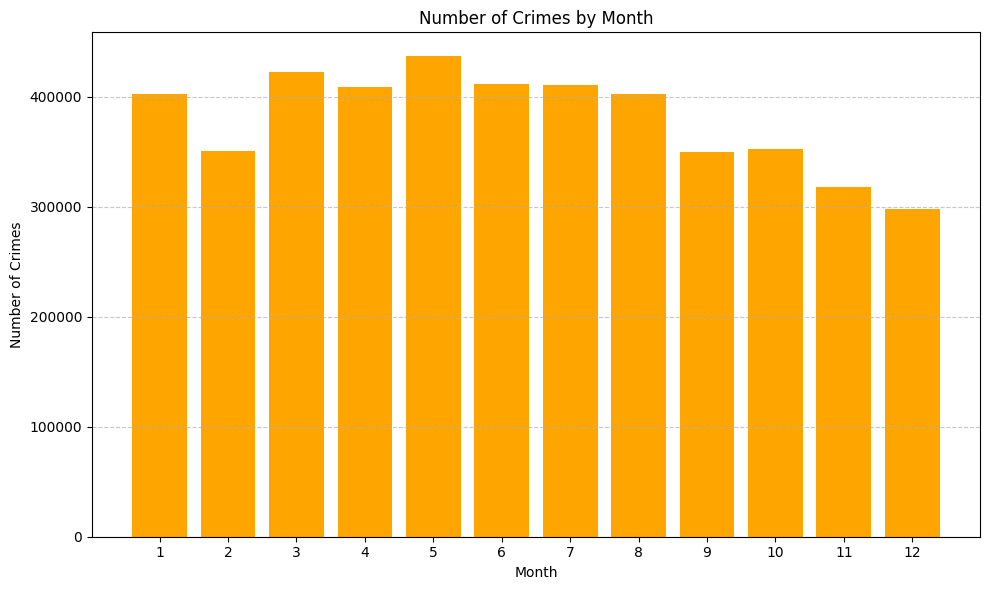

In [ ]:
# Retrieve data
crime_by_month_data = crime_by_month.collect()

# Split into lists
months = [item[0] for item in crime_by_month_data]
crime_counts_month = [item[1] for item in crime_by_month_data]

# Plot graph
plt.figure(figsize=(10, 6))
plt.bar(months, crime_counts_month, color='orange')
plt.title('Number of Crimes by Month')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.xticks(months)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show graph
plt.show()

In [ ]:
# Function to map months to seasons
def get_season(month):
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Autumn'
    else:
        return 'Winter'

# Map months to seasons
crime_by_season = rdd.map(lambda row: (get_season(row[2]), 1)).reduceByKey(lambda x, y: x + y).sortByKey()

# Collect and print the result
crime_by_season.collect()

[('Autumn', 1020062),
 ('Spring', 1268295),
 ('Summer', 1224268),
 ('Winter', 1051477)]

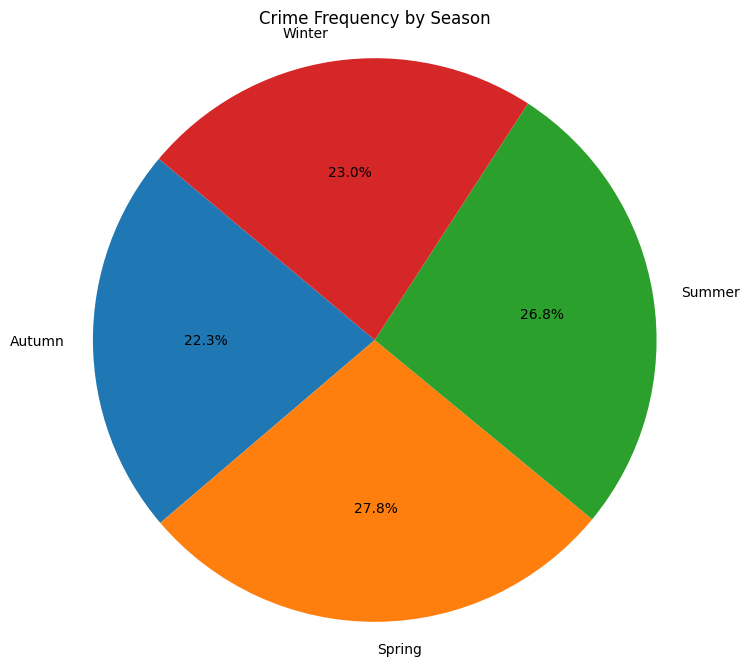

In [ ]:
# Extract season and crime count data
seasons = [season_count[0] for season_count in crime_by_season.collect()]
crime_counts = [season_count[1] for season_count in crime_by_season.collect()]

# Plotting
plt.figure(figsize=(8, 8))
plt.pie(crime_counts, labels=seasons, autopct='%1.1f%%', startangle=140)
plt.title('Crime Frequency by Season')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [ ]:
# Function to convert hour to AM/PM format with time indication
def convert_to_ampm_with_time(hour):
    if hour == 0:
        return '12 AM'
    elif hour < 12:
        return f'{hour} AM'
    elif hour == 12:
        return '12 PM'
    else:
        return f'{hour - 12} PM'

# Group data by time
grouped_crime_by_hour = rdd.map(lambda row: (convert_to_ampm_with_time(row[3]), 1)).groupByKey()

# Count crimes in each time interval
crime_by_hour_with_time = grouped_crime_by_hour.mapValues(lambda x: sum(x))

# Sort results by time
sorted_crime_by_hour_with_time = crime_by_hour_with_time.sortByKey()

# Split into AM and PM
crime_by_hour_am = sorted_crime_by_hour_with_time.filter(lambda x: 'AM' in x[0])
crime_by_hour_pm = sorted_crime_by_hour_with_time.filter(lambda x: 'PM' in x[0])

# Sort results within AM and PM
crime_by_hour_am = sorted(crime_by_hour_am.collect(), key=lambda x: (int(x[0].split()[0]) % 12))
crime_by_hour_pm = sorted(crime_by_hour_pm.collect(), key=lambda x: (int(x[0].split()[0]) % 12))

print("Crimes by Time (AM):")
print(crime_by_hour_am)
print("\nCrimes by Time (PM):")
print(crime_by_hour_pm)

Crimes by Time (AM):
[('12 AM', 256236), ('1 AM', 146275), ('2 AM', 122213), ('3 AM', 98306), ('4 AM', 73353), ('5 AM', 60022), ('6 AM', 70321), ('7 AM', 102433), ('8 AM', 152776), ('9 AM', 194333), ('10 AM', 191048), ('11 AM', 200985)]

Crimes by Time (PM):
[('12 PM', 256668), ('1 PM', 216669), ('2 PM', 230250), ('3 PM', 241762), ('4 PM', 227014), ('5 PM', 230868), ('6 PM', 249572), ('7 PM', 260042), ('8 PM', 261926), ('9 PM', 257703), ('10 PM', 254485), ('11 PM', 208842)]


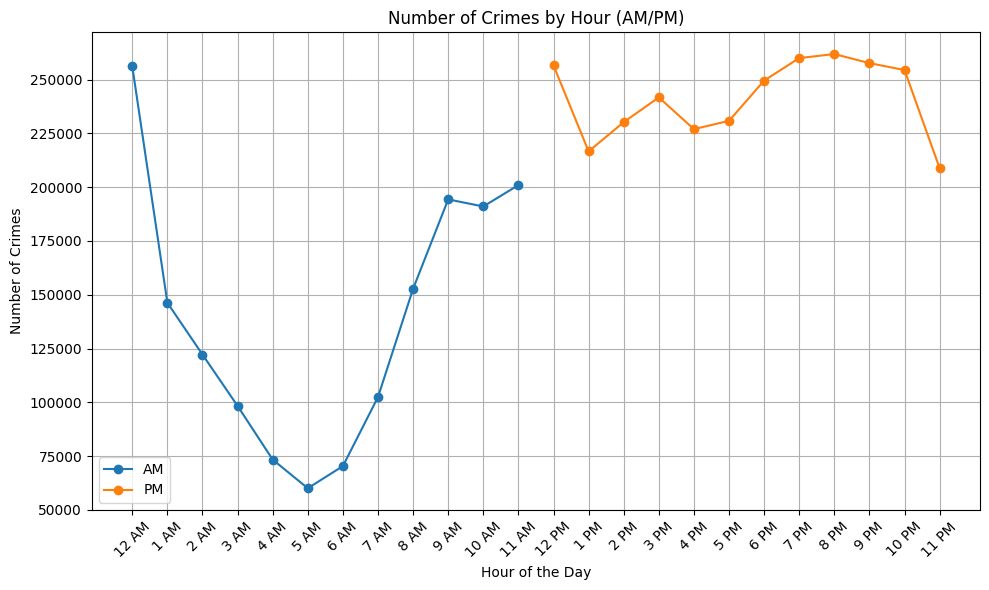

In [ ]:
# Data for the graph
hours_am = [item[0] for item in crime_by_hour_am]
crime_counts_am = [item[1] for item in crime_by_hour_am]

hours_pm = [item[0] for item in crime_by_hour_pm]
crime_counts_pm = [item[1] for item in crime_by_hour_pm]

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(hours_am, crime_counts_am, marker='o', label='AM')
plt.plot(hours_pm, crime_counts_pm, marker='o', label='PM')
plt.title('Number of Crimes by Hour (AM/PM)')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

In [ ]:
# Load data into DataFrame
data = sc.read.csv("/content/Chicago_Crimes_2001_to_2017.csv", header=True, inferSchema=True)

# Filter data where Arrest is True
arrested_crimes = data.filter(data['Arrest'] == True)

# Calculate statistics
crime_statistics = arrested_crimes.groupBy('Primary Type').count().orderBy('count', ascending=False)

# Show the statistics
crime_statistics.show()

+--------------------+------+
|        Primary Type| count|
+--------------------+------+
|           NARCOTICS|510490|
|             BATTERY|192696|
|               THEFT|115702|
|   CRIMINAL TRESPASS| 99595|
|             ASSAULT| 66510|
|        PROSTITUTION| 50140|
|       OTHER OFFENSE| 48711|
|     CRIMINAL DAMAGE| 38524|
|   WEAPONS VIOLATION| 35659|
|  DECEPTIVE PRACTICE| 32314|
|PUBLIC PEACE VIOL...| 21758|
| MOTOR VEHICLE THEFT| 19938|
|             ROBBERY| 17429|
|            BURGLARY| 15766|
|            GAMBLING| 10549|
|LIQUOR LAW VIOLATION| 10397|
|INTERFERENCE WITH...|  8425|
|OFFENSE INVOLVING...|  6564|
|         SEX OFFENSE|  5406|
| CRIM SEXUAL ASSAULT|  2863|
+--------------------+------+
only showing top 20 rows



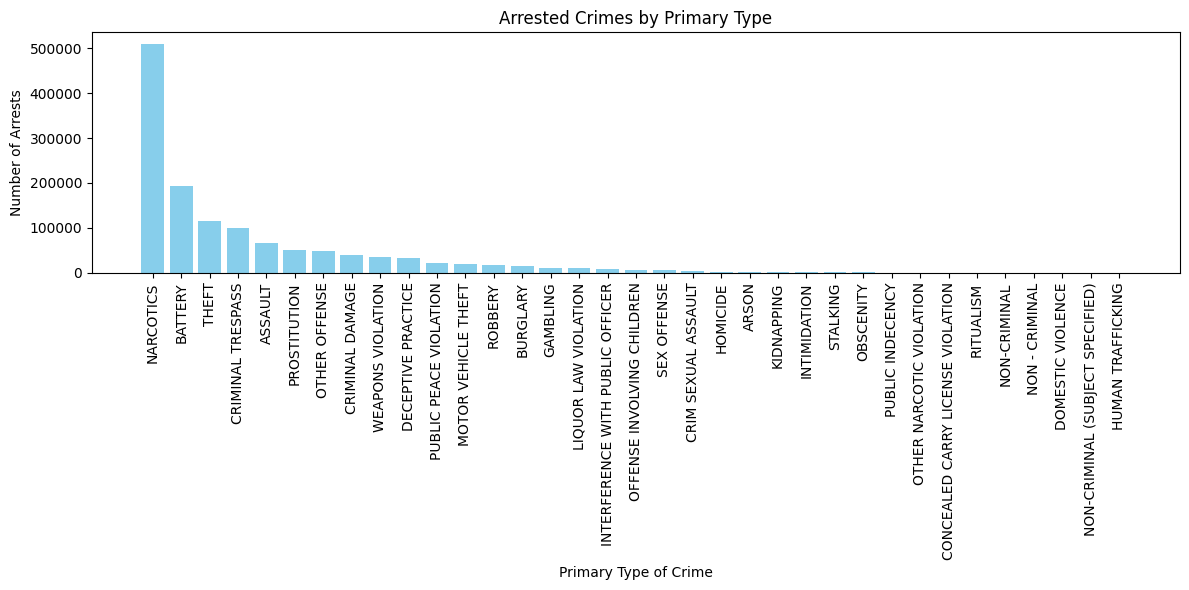

In [ ]:
# Convert DataFrame to Pandas DataFrame for plotting
crime_statistics_pd = crime_statistics.toPandas()

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(crime_statistics_pd['Primary Type'], crime_statistics_pd['count'], color='skyblue')
plt.xlabel('Primary Type of Crime')
plt.ylabel('Number of Arrests')
plt.title('Arrested Crimes by Primary Type')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

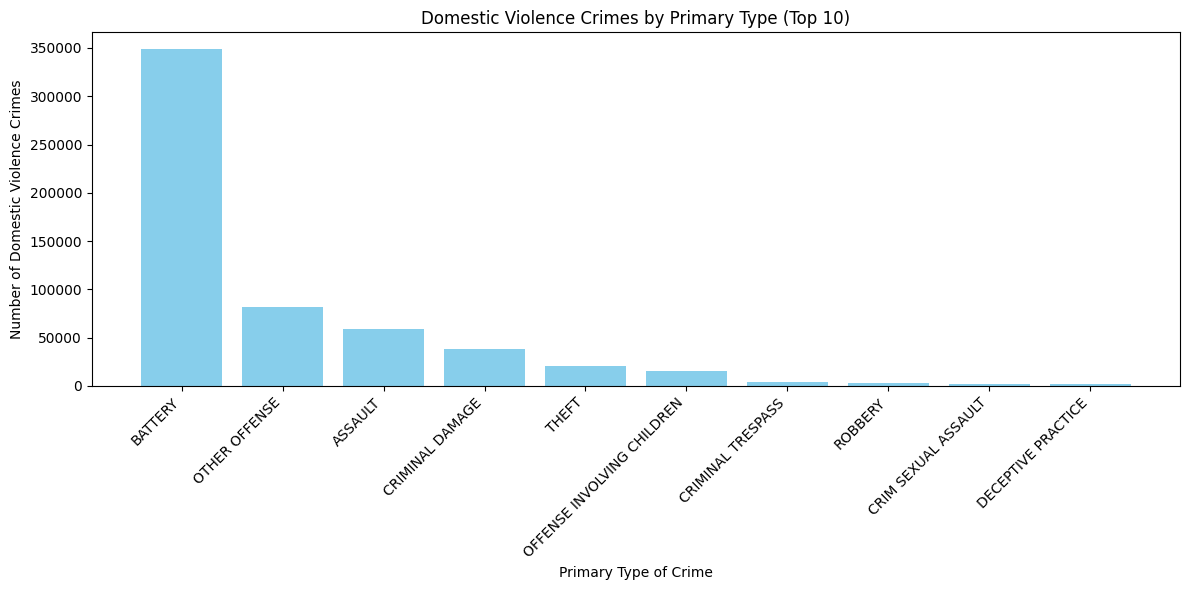

In [ ]:
# Count the number of domestic violence crimes by primary type Top 10
domestic_violence_stats = data.filter(data['Domestic'] == True) \
    .groupBy('Primary Type').count() \
    .orderBy('count', ascending=False) \
    .limit(10) \
    .toPandas()

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(domestic_violence_stats['Primary Type'], domestic_violence_stats['count'], color='skyblue')
plt.xlabel('Primary Type of Crime')
plt.ylabel('Number of Domestic Violence Crimes')
plt.title('Domestic Violence Crimes by Primary Type (Top 10)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

In [ ]:
sc.stop()

In [ ]:
spark = SparkSession.builder \
    .appName("CrimeDataAnalysis") \
    .getOrCreate()

# Чтение данных в DataFrame с помощью PySpark SQL
crime_data = spark.read.csv("/content/Chicago_Crimes_2001_to_2017.csv", header=True, inferSchema=True)

In [ ]:
crime_by_location_spark = crime_data.groupBy('Location Description').count().orderBy('count', ascending=False)

# Displaying the top 10 crime locations in Chicago.
print("Top 10 crime locations in Chicago:")
crime_by_location_spark.show(10)

Top 10 crime locations in Chicago:
+--------------------+-------+
|Location Description|  count|
+--------------------+-------+
|              STREET|1209187|
|           RESIDENCE| 776301|
|            SIDEWALK| 462596|
|           APARTMENT| 455991|
|               OTHER| 172490|
|PARKING LOT/GARAG...| 129576|
|               ALLEY| 103645|
|SCHOOL, PUBLIC, B...| 102150|
|    RESIDENCE-GARAGE|  90477|
|RESIDENCE PORCH/H...|  80117|
+--------------------+-------+
only showing top 10 rows



In [ ]:
# Grouping crime data by district, counting the occurrences, and ordering them in ascending order by district number.
crime_by_district = crime_data.groupBy('District').count().orderBy('District', ascending=True)

# Displaying the results
print("Number of crimes by Chicago County:")
crime_by_district.show(32)

Number of crimes by Chicago County:
+--------+------+
|District| count|
+--------+------+
|     0.0|    46|
|     1.0|164770|
|     2.0|223566|
|     3.0|234850|
|     4.0|259710|
|     5.0|203851|
|     6.0|261944|
|     7.0|272933|
|     8.0|314567|
|     9.0|228277|
|    10.0|192334|
|    11.0|288505|
|    12.0|220465|
|    13.0|     1|
|    14.0|180837|
|    15.0|201998|
|    16.0|151585|
|    17.0|132503|
|    18.0|194389|
|    19.0|202790|
|    20.0| 80240|
|    22.0|150729|
|    24.0|137217|
|    25.0|265920|
|    31.0|    75|
+--------+------+



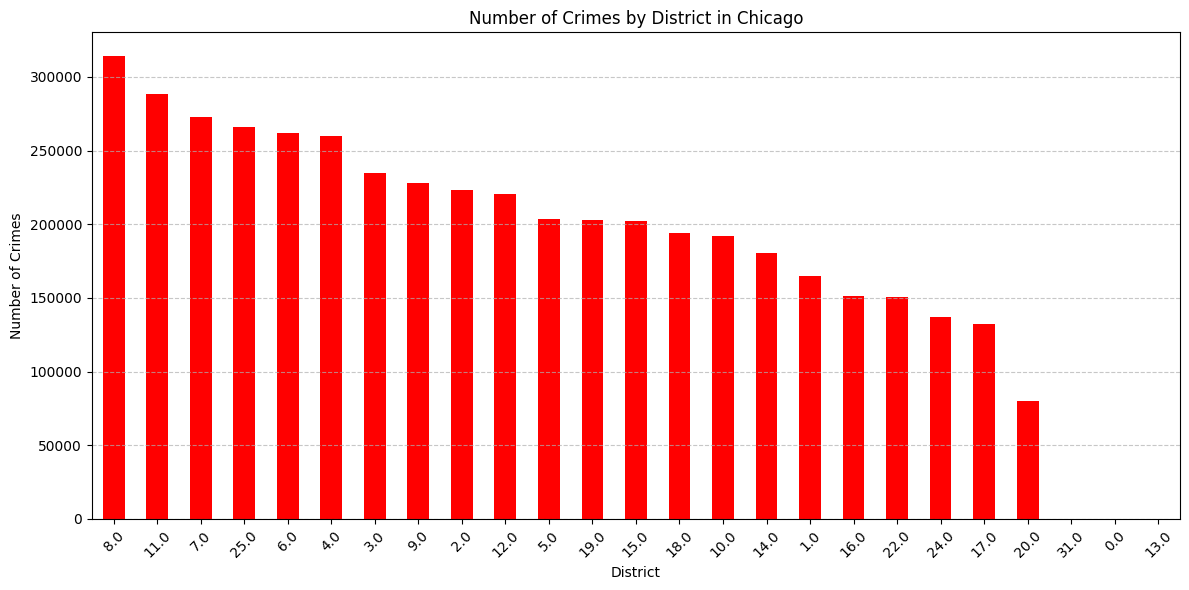

In [ ]:
# Grouping data by district, counting the number of crimes in each district
crime_by_district = crimes_2001_2017['District'].value_counts()

# Creating a bar plot
plt.figure(figsize=(12, 6))
crime_by_district.plot(kind='bar', color='red')
plt.title('Number of Crimes by District in Chicago')
plt.xlabel('District')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Grouping data by primary type of crime and district, counting the occurrences, and resetting index with count column renamed
crime_by_type_district = crimes_2001_2017.groupby(['Primary Type', 'District']).size().reset_index(name='CrimeCount')

# Finding the most common crime type in each district
most_common_crime_by_district = crime_by_type_district.groupby('District').apply(lambda x: x.loc[x['CrimeCount'].idxmax()])

# Displaying the results
print("Most common crime type in each district of Chicago:")
print(most_common_crime_by_district[['Primary Type']])

Most common crime type in each district of Chicago:
                Primary Type
District                    
0.0       DECEPTIVE PRACTICE
1.0                    THEFT
2.0                  BATTERY
3.0                  BATTERY
4.0                  BATTERY
5.0                  BATTERY
6.0                  BATTERY
7.0                  BATTERY
8.0                    THEFT
9.0                  BATTERY
10.0                 BATTERY
11.0               NARCOTICS
12.0                   THEFT
13.0           OTHER OFFENSE
14.0                   THEFT
15.0               NARCOTICS
16.0                   THEFT
17.0                   THEFT
18.0                   THEFT
19.0                   THEFT
20.0                   THEFT
22.0                   THEFT
24.0                   THEFT
25.0                   THEFT
31.0               NARCOTICS


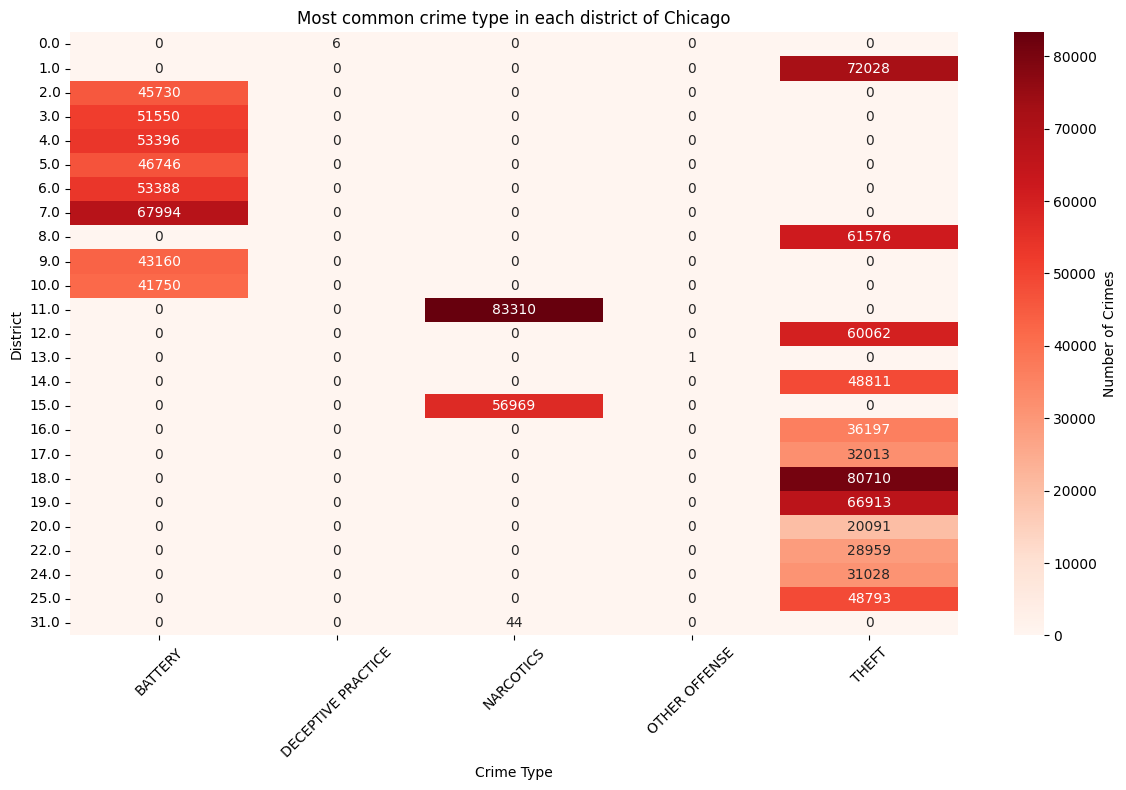

In [ ]:
# Grouping data by type of crime and district, counting the occurrences
crime_by_type_district = crimes_2001_2017.groupby(['Primary Type', 'District']).count().reset_index()

# Finding the most common crime type in each district
most_common_crime_by_district = crime_by_type_district.loc[crime_by_type_district.groupby('District')['ID'].idxmax()]

# Converting data for visualization into a table format
crime_table = most_common_crime_by_district.pivot(index='District', columns='Primary Type', values='ID').fillna(0)

# Visualizing the table
plt.figure(figsize=(12, 8))
sns.heatmap(crime_table, cmap='Reds', annot=True, fmt='g', cbar_kws={'label': 'Number of Crimes'})
plt.title('Most common crime type in each district of Chicago')
plt.xlabel('Crime Type')
plt.ylabel('District')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# Grouping data by district and counting the number of crimes in each district
crime_per_area = crimes_2001_2017.groupby('District').size()

# Calculating the average number of crimes
average_crime_per_area = np.mean(crime_per_area)

# Displaying the results
print("Average number of crimes in each district of Chicago:")
print(crime_per_area)
print("\nAverage number of crimes:", average_crime_per_area)

Average number of crimes in each district of Chicago:
District
0.0         46
1.0     164770
2.0     223566
3.0     234850
4.0     259710
5.0     203851
6.0     261944
7.0     272933
8.0     314567
9.0     228277
10.0    192334
11.0    288505
12.0    220465
13.0         1
14.0    180837
15.0    201998
16.0    151585
17.0    132503
18.0    194389
19.0    202790
20.0     80240
22.0    150729
24.0    137217
25.0    265920
31.0        75
dtype: int64

Average number of crimes: 182564.08


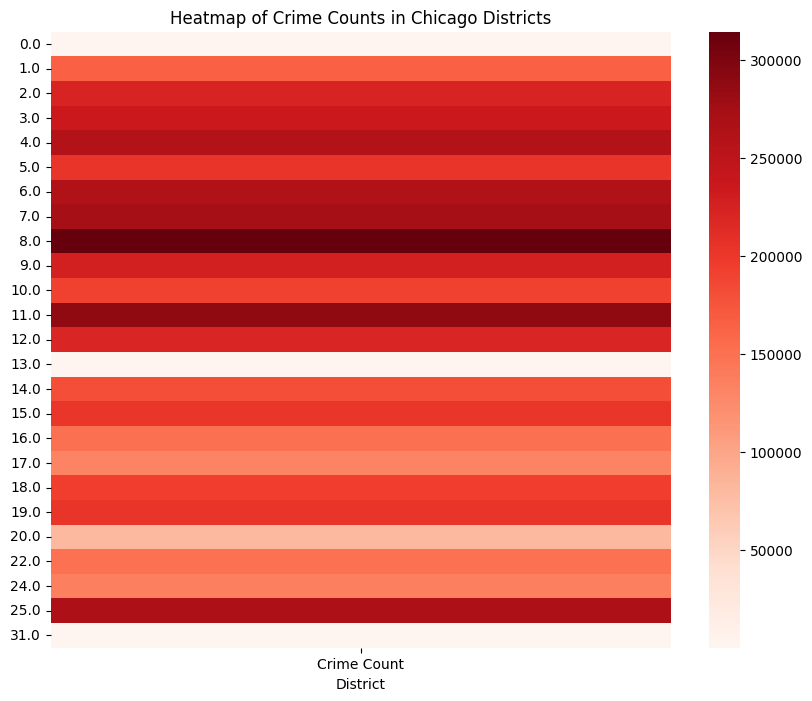

In [ ]:
# Grouping data by district and counting the number of crimes in each district
crime_per_area = crimes_2001_2017.groupby('District').size()

# Converting Series to DataFrame for easier data manipulation
crime_per_area = crime_per_area.reset_index(name='Crime Count')

# Creating a matrix for the heatmap
heatmap_data = pd.pivot_table(crime_per_area, values='Crime Count', index='District', aggfunc=np.sum)

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='Reds')
plt.title('Heatmap of Crime Counts in Chicago Districts')
plt.xlabel('District')
plt.ylabel('')

plt.show()

In [ ]:
# Grouping data by FBI code and counting the number of crimes for each code
crime_per_fbi_code = crimes_2001_2017.groupby('FBI Code').size()

# Displaying the results
print("Number of crimes for each FBI code:")
print(crime_per_fbi_code)

Number of crimes for each FBI code:
FBI Code
01A      3910
01B        16
02      19382
03     170692
04A     69122
04B    120936
05     264762
06     937934
07     212278
08A    211071
08B    715744
09       7424
10      24345
11     131647
12        925
13       1983
14     530344
15      44112
16      50425
17      20510
18     481143
19      10832
20      16673
22      10512
24      33175
26     474205
dtype: int64


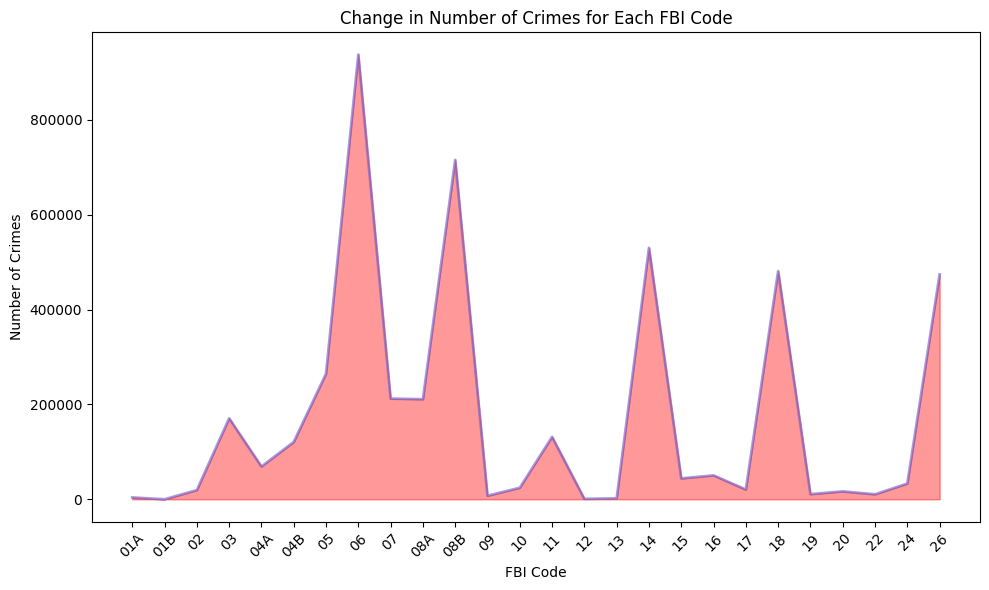

In [ ]:
# Grouping data by FBI code and counting the number of crimes for each code, then resetting index and renaming the count column
crime_per_fbi_code = crimes_2001_2017.groupby('FBI Code').size().reset_index(name='Count')

# Creating an area plot
plt.figure(figsize=(10, 6))
plt.fill_between(crime_per_fbi_code.index, crime_per_fbi_code['Count'], color='red', alpha=0.4)
plt.plot(crime_per_fbi_code.index, crime_per_fbi_code['Count'], color='Slateblue', alpha=0.6, linewidth=2)

plt.xlabel('FBI Code')
plt.ylabel('Number of Crimes')
plt.title('Change in Number of Crimes for Each FBI Code')
plt.xticks(crime_per_fbi_code.index, crime_per_fbi_code['FBI Code'], rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Grouping crime data by block, counting the occurrences, and ordering them in ascending order by block name
crime_by_district = crime_data.groupBy('Block').count().orderBy('Block', ascending=True)

# Displaying the results
print("Number of crimes by block in Chicago:")
crime_by_district.show(100)

Number of crimes by block in Chicago:
+------------------+-----+
|             Block|count|
+------------------+-----+
|0000X  I94/EXIT 12|    1|
|    0000X E 100 PL|   44|
|    0000X E 100 ST|   44|
|  0000X E 100TH PL|  338|
|  0000X E 100TH ST|  248|
|    0000X E 101 PL|   10|
|    0000X E 101 ST|   30|
|  0000X E 101ST PL|  191|
|  0000X E 101ST ST|  251|
|    0000X E 102 PL|   19|
|    0000X E 102 ST|   16|
|  0000X E 102ND PL|  401|
|  0000X E 102ND ST|  210|
|    0000X E 103 PL|   11|
|    0000X E 103 ST|   29|
|  0000X E 103RD PL|  125|
|  0000X E 103RD ST|  352|
|    0000X E 104 ST|   18|
|  0000X E 104TH ST|  134|
|    0000X E 105 ST|   23|
|  0000X E 105TH ST|  104|
|    0000X E 107 ST|   13|
|  0000X E 107TH ST|  143|
|    0000X E 108 ST|   10|
|  0000X E 108TH ST|   74|
|  0000X E 109TH ST|   36|
|     0000X E 11 ST|    6|
|    0000X E 110 PL|   29|
|    0000X E 110 ST|   15|
|  0000X E 110TH PL|  231|
|  0000X E 110TH ST|   56|
|    0000X E 111 PL|    8|
|    0000X E 111 

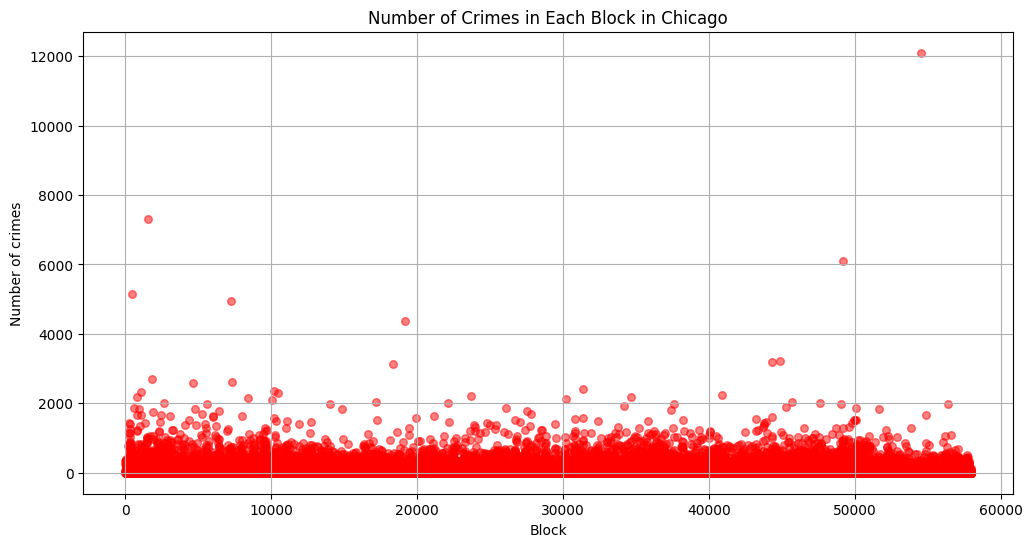

In [ ]:
# Grouping data by block and counting the number of crimes in each block, then resetting index and renaming the count column
crime_per_block = crimes_2001_2017.groupby('Block').size().reset_index(name='Count')

# Creating a scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(crime_per_block.index, crime_per_block['Count'], s=30, alpha=0.5, color='red')
plt.xlabel('Block')
plt.ylabel('Number of crimes')
plt.title('Number of Crimes in Each Block in Chicago')
plt.grid(True)
plt.show()

In [ ]:
spark.stop()